In [35]:
!pip install --quiet -U langgraph langchain_ollama langchain_core

**States** are the first things defined about the graph. These consist of the schema of the graph, and reducer functions to specify how to apply state updates.

In [4]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

**Nodes** are python functions (synchronous or asynchronous). The first positional argument is the state.

In [6]:
def node_1(state):
    print("---Node 1---")
    return {"graph state": state['graph_state'] + " I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph state": state['graph_state'] + " happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph state": state['graph_state'] + " sad!"}

**Schemas** are typically constructed in `TypedDict` types. `Pydantic` base models can also be used.

In [7]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(InputState, OutputState):
    pass

def answer_node(state: InputState):
    return {"answer": "bye", "question": state["question"]}

builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node(answer_node)
builder.add_edge(START, "answer_node")
builder.add_edge("answer_node", END)
graph = builder.compile()

print(graph.invoke({"question": "hi"}))

{'answer': 'bye'}


**Edges** connect each node. Normal edges are used if you want to always go from like `node_1` to `node_2`.
**Conditional edges** are used if you want optional routes between various nodes.
 ```python
graph.add_conditional_edges("node_1", routing_function)
```
The Routing function accepts current states of the graph, and returns a value. The default return value is used as the name of node or list of nodes to send the state to the next. Similar to functional programming chains.

You can also provide a dictionary of optional routes.
```python
graph.add_conditional_edges("node_a", routing_function, {True: "node_b", False: "node_c"})
```

In [8]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    user_input = state['graph_state']
    if random.random() < 0.5:
        return "node_2"
    return "node_3"

Once components have been defined above, they can be added to a graph. Start with a **StateGraph** class.

The **StateGraph** class is the main graph class at this point. It's parameterized by a user defined `State` object.

Initialize a StateGraph with `State` class as defined above:
```python
class State(TypedDict):
    graph_state: str
```

We use START nodes, that sends user input to the graph, to indicate where to start on the graph.
The **START** node is a special node that represents the node that sends user input ot the graph, and the main purpose for referencing this node is to determine which nodes should be called first.

```python
from langgraph.graph import START
graph.add_edge(START, "node_a")
```
The `END` node is a special node that represents a terminal node, and is referenced when you want to denote which edges have no actions after they are complete.

```python
from langgraph.graph import END

graph.add_edge("node_a", END)
```

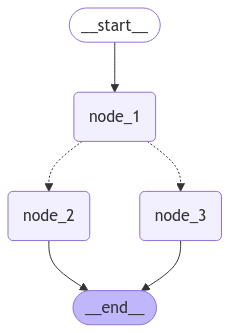

In [9]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
graph.invoke({"graph_state": "Hi, this is Adam."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Adam.'}

In [34]:
result = await graph.ainvoke({"graph_state": "Hello there!"})

---Node 1---
---Node 2---


# Tools
**Tools** are utilities designed to be called by a model: their inputs are designed to be generated by models, and their outputs are designed to be passed back to models. Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

A **tool** consists of:
1. The `name` of the tool.
2. A `description` of what the tool does.
3. A `JSON schema` defining the inputs of the tool.
4. A `function` (and, optionally, an async variant of the function).

When a **tool** is bound to a model, the name, description, and JSON schema are provided as context to the model.

Given a list of tools and a set of instructions, a model can request to call one ore more tools with specific inputs.

```python
tools = [...]
llm_with_tools = llm.bind_tools(tools)
ai_msg = llm_with_tools.invoke("do xyz...")
```

The `AIMessage` returned from the model **MAY** have `tool_calls` associated with it.

Tool calling allows a chat model to respond to a given prompt by generating output that matches a user-defined schema.

```python
AIMessage(
    tool_calls=[{
        name: "get_weather",
        args: {
            location: "Hawaii",
        },
    }]
)
```

HumanMessage, AIMessage, SystemMessage, and ToolMessage.

Let's run through each type of message.

In [36]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Adam"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Adam"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Adam

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Adam

I want to learn about the best place to see Orcas in the US.


In [37]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model="deepseek-r1:7b")
result = llm.invoke(messages)
type(result)

result

AIMessage(content='<think>\nOkay, so the user asked for information on the best places to see Orcas in the US. I already told them they were researching ocean mammals and then asked which aspect they wanted info on. Now, they\'ve specified focusing on Orcas.\n\nI need to provide a list of top locations with some details about each. The previous response included Alaska\'s Haida Gorda Peninsula as the top spot because it has multiple Orcas sightings. So maybe I should start there and include other states like Washington for Orcas in WA and Idaho for Northern Orcas.\n\nI should explain why these places are good—maybe mention the number of sightings, how local regulations make the experience better. Also, tips like timing their visit during peak seasons or making reservations would be helpful.\n\nI should also highlight some specific attractions related to seeing Orcas, like boat tours, viewing areas, and nearby wildlife. Maybe add a tip about not overdoing it with Orcas to respect them w

In [38]:
result.response_metadata

{'model': 'deepseek-r1:7b',
 'created_at': '2025-02-24T05:46:09.51689Z',
 'done': True,
 'done_reason': 'stop',
 'total_duration': 23909153833,
 'load_duration': 571233333,
 'prompt_eval_count': 49,
 'prompt_eval_duration': 5277000000,
 'eval_count': 806,
 'eval_duration': 17820000000,
 'message': Message(role='assistant', content='', images=None, tool_calls=None)}

When a model has to interact with external systems you have to use **tools**.

In [39]:
def multiply(a: int, b: int) -> int:
    return a * b

llm_with_tools = llm.bind_tools([multiply])

tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multipled by 3", name="Adam")])

ResponseError: registry.ollama.ai/library/deepseek-r1:7b does not support tools (status code: 400)

In [40]:
tool_call.tool_calls

NameError: name 'tool_call' is not defined

In [41]:
import os
from langchain_openai import ChatOpenAI
os.environ["OPENAI_API_KEY"] = os.environ.get("OPEN_AI_KEY")

llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [42]:
result

AIMessage(content='The best place to see orcas, also known as killer whales, in the United States is the Pacific Northwest, particularly the waters around the San Juan Islands in Washington State. Known for their breathtaking natural beauty, these islands are a hotspot for orca watching.\n\nOrcas are frequently sighted in the waters around these islands, especially during the summer months when salmon, their primary food source, are abundant. The resident orca pods, known as the Southern Resident Killer Whales, are often seen here. Tours depart from places like Friday Harbor on San Juan Island, as well as from Anacortes and Seattle on the mainland.\n\nApart from the San Juan Islands, the Strait of Juan de Fuca and Puget Sound also provide excellent opportunities for orca watching. These areas are rich in marine life, making them ideal habitats for orcas.\n\nRemember that orca watching tours can have varying impacts on the whales, so it’s beneficial to choose operators that follow guide

In [43]:
llm_with_tools = llm.bind_tools([multiply])
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Adam")])

In [44]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_ubsmaPiqSuzsDxte87VJrnya',
  'type': 'tool_call'}]

In [45]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers
**Reducers** are key to understanding how updates from nodes are applied to the `State`. Each key in the `State` has its own independent reducer function. If no reducer function is explicitly specified then it is assumed that all updates to that key should override it.